## Modelo de Regressão Logística - Desenvolvimento

In [219]:
from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

input_path = r'D:\Github\Forked\crypto_technical_analysis\files\crypto_data_with_indicators.parquet'

dados = pd.read_parquet(input_path)

In [ ]:
# Filter data for study
symbols_filter = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'LTC-USD', 'DOGE-USD', 'MATIC-USD', 'LINK-USD', 'NEAR-USD']
# symbols_filter = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'DOGE-USD', 'TON-USD', 'TRX-USD', 'AVAX-USD', 'SHIB-USD', 'DOT-USD', 'LINK-USD', 'BCH-USD', 'MATIC-USD', 'NEAR-USD', 'LTC-USD', 'UNI-USD', 'XMR-USD', 'XLM-USD', 'APT-USD', 'RNDR-USD', 'HBAR-USD']

dados = dados[dados['Symbol'].isin(symbols_filter)]

In [220]:
def data_clean(dados:pd.DataFrame, target_list:list, data_return:str):
    # Removing NA
    dados_treat = dados.dropna()

    # Substituindo valores infinitos por NaN
    dados_treat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Removendo linhas com valores NaN
    dados_treat.dropna(inplace=True)

    # Removing columns that won't be use in the model
    removing_cols = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

    # Define the target in a list of target (for futher iteration)
    dados_y = dados_treat[target_list]

    # Removing target from base to avoid data leakage
    dados_x = dados_treat.drop(dados_treat[target_list], axis=1)
    dados_x = dados_treat.drop(dados_treat[removing_cols], axis=1)

    if data_return == 'Y':
        return dados_y
    else:
        return dados_x

In [221]:
def get_target(dados_y:pd.DataFrame, col_target:str):
    return dados_y[col_target]

In [222]:

import preprocessing_data as preprocessing

target_list_bol =   [
    # boleanos
    'bl_target_10_7d','bl_target_15_7d','bl_target_20_7d','bl_target_25_7d',
    'bl_target_10_15d','bl_target_15_15d','bl_target_20_15d','bl_target_25_15d', 
    'bl_target_10_30d','bl_target_15_30d','bl_target_20_30d','bl_target_25_30d' 
]

target_list_val =   [
    # percentual
    'target_10_7d','target_15_7d','target_20_7d','target_25_7d',
    'target_10_15d','target_15_15d','target_20_15d','target_25_15d', 
    'target_10_30d','target_15_30d','target_20_30d','target_25_30d', 
]

remove_target_list = target_list_bol + target_list_val

dados_x = data_clean(dados, remove_target_list, 'X')
dados_y_all = data_clean(dados, remove_target_list, 'Y')

C:\Users\mathe\AppData\Local\Temp\ipykernel_14452\3108373152.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_treat.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_14452\3108373152.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_treat.dropna(inplace=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_14452\3108373152.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_

In [223]:
dados_y = get_target(dados_y_all, target_list_bol[0])

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [225]:
def split_data(dados_x:pd.DataFrame, dados_y:pd.DataFrame, test_size:float=0.3):

    # Getting dummies values. This way we can use categorical columns to train the models
    dummies = pd.get_dummies(dados_x)

    # Transform the data in numpy arrays
    X = np.array(dummies.values)
    y = np.array(dados_y.values)

    # This function returns X_train, X_test, y_train, y_test, in this order.
    # See below an example of the return 
    # X_train, X_test, y_train, y_test = split_data(dados_x, dados_y, 0.3)

    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=45)

X_train, X_test, y_train, y_test = split_data(dados_x, dados_y, 0.3)

In [226]:
# Verificando o desbalanceamento de classes

# Supondo que 'y' seja o vetor de rótulos
print(pd.Series(y_train).value_counts(normalize=True))

0    0.81238
1    0.18762
Name: proportion, dtype: float64


In [227]:
# Balanceando as classes 
from imblearn.under_sampling import RandomUnderSampler # pip install imblearn
from imblearn.over_sampling import SMOTE

def balance_sample(X_train, y_train, type):

    # Reduzir amostra
    if type == 1:
        undersampler = RandomUnderSampler(random_state=42)
        return undersampler.fit_resample(X_train, y_train)

    # Aumentar amostra
    if type == 2:
        smote = SMOTE(random_state=42)
        return smote.fit_resample(X_train, y_train)
    
    # Sem mudanças
    if type == 0:
        return X_train, y_train   

In [228]:
X_train, y_train = balance_sample(X_train, y_train, 2)

In [229]:
# Contar os valores 1
count_1 = np.count_nonzero(y_train == 1)

# Contar os valores 0
count_0 = np.count_nonzero(y_train == 0)

# Contar os valores 1
count_1t = np.count_nonzero(y_test == 1)

# Contar os valores 0
count_0t = np.count_nonzero(y_test == 0)

print(count_1, count_0)
print(count_1t, count_0t)

8465 8465
838 3629


In [230]:
def norm_scale(X_norm_scale):

    # normalizando e padronizando os dados
    # MinMaxScaler é usado para normalizar as variáveis, e StandardScaler é usado para padronizar
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    # normalizando
    scaler = MinMaxScaler()
    scaler.fit(X_norm_scale)
    normalized_data = scaler.transform(X_norm_scale)
    # print(normalized_data)

    # Padronizando
    scaler = StandardScaler()
    scaler.fit(X_norm_scale)
    standardized_data = scaler.transform(X_norm_scale)
    # print(standardized_data)

    # print(standardized_data.shape)

    X_norm_scale = standardized_data
    
    return X_norm_scale

In [231]:
# Normalizando datasets de treino e teste
norm_scale(X_train)
norm_scale(X_test)

array([[-0.34585606, -0.34615592, -0.34719149, ..., -0.97152675,
        -0.22099266, -0.01496376],
       [-0.34501222, -0.34515001, -0.3460901 , ...,  1.02930773,
        -0.22099266, -0.01496376],
       [ 1.70878101,  1.71551879,  1.76126474, ..., -0.97152675,
        -0.22099266, -0.01496376],
       ...,
       [-0.34463435, -0.34484569, -0.34572026, ..., -0.97152675,
        -0.22099266, -0.01496376],
       [-0.34588379, -0.34618259, -0.3472173 , ..., -0.97152675,
        -0.22099266, -0.01496376],
       [ 1.96778441,  2.02489086,  2.0894618 , ..., -0.97152675,
        -0.22099266, -0.01496376]])

In [232]:
# Criando o modelo
model = LogisticRegression(class_weight='balanced',random_state=0,max_iter=1000000)

# Treinando o modelo
model.fit(X_train, y_train)

clf = LogisticRegression(random_state=45,max_iter=1000).fit(X_train, y_train)

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

In [233]:
def eval_model(classifier, X_test, y_test):

    from sklearn.metrics import confusion_matrix
    from sklearn import metrics

    # Fazendo a previsão das classes
    y_pred2 = clf.predict(X_test)

    # Avaliando o erro
    print('Confusion Matrix')
    print(confusion_matrix(y_test,y_pred2))

    # Avaliando o modelo 
    # score = model.score(X_test, y_test)
    score = metrics.accuracy_score(y_test, y_pred2)

    # Percentagem de acerto
    print('Acurácia:', score)

In [234]:
eval_model(clf, X_test, y_test)

Confusion Matrix
[[3341  288]
 [  87  751]]
Acurácia: 0.916051040967092


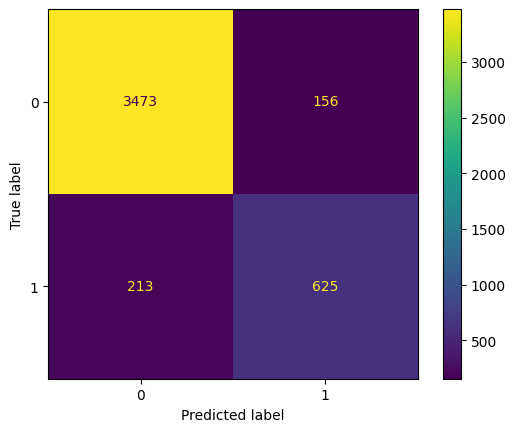

In [201]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

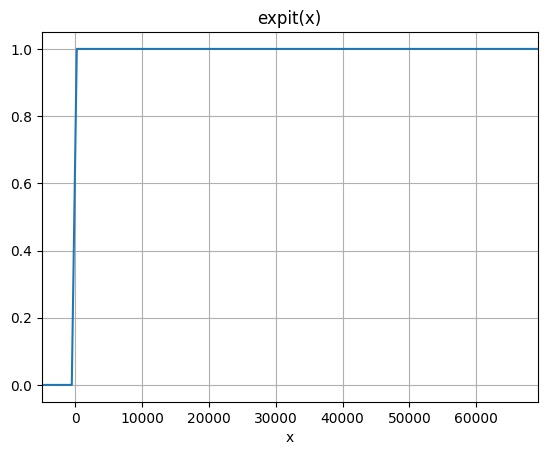

In [235]:
# Visualizando o gráfico

import matplotlib.pyplot as plt
from scipy.special import expit

x = np.linspace(X_train.min(), X_train.max(), 100)
y = expit(x)
plt.plot(x, y)
plt.grid()
plt.xlim(X_train.min(), X_train.max())
plt.xlabel('x')
plt.title('expit(x)')
plt.show()

In [236]:
def save_model(classifier, name_model:str):
    # Lib to save the model in a compressed way
    import joblib

    # Save the model that has been trained
    joblib.dump(classifier, name_model + '.joblib')

    print(f'Modelo savo no diretório atual com o nome de {name_model}.joblib')

In [237]:
def load_model(name_model:str):
    # Lib to save the model in a compressed way
    import joblib

    # Load the trained model
    clf_loaded = joblib.load(name_model + '.joblib')

    return clf_loaded

In [46]:
nome_modelo = 'logistic_regression_model_bl_target_10_7d'
save_model(clf, nome_modelo)

Modelo savo no diretório atual com o nome de logistic_regression_model_bl_target_10_7d.joblib
